In [1]:
import numpy as np
from gpu_xray_scattering import XS
from gpu_xray_scattering.Molecule import Molecule
import glob
import MDAnalysis as mda
from MDAnalysis.topology.guessers import guess_types
from scipy.ndimage import binary_erosion, binary_dilation
import numpy.polynomial.polynomial as poly

def readPDB(fname, sel='protein', sel2=None, psf=None):
    if psf is not None:
        U = mda.Universe(psf, fname)
    else:
        U = mda.Universe(fname)
    Usel = U.select_atoms(sel)
    try:
        print(Uele[:3])
        Uele = Usel.elements
    except:
        guessed_elements = guess_types(U.atoms.names)
        U.add_TopologyAttr('elements', guessed_elements)
        
    
    if sel2 is not None:
        Usel2 = U.select_atoms(sel2)
        return Usel.positions, Usel.elements, Usel2.positions, Usel2.elements
    else:
        return Usel.positions, Usel.elements


In [148]:
all_coord, all_ele, ligand_coord, ligand_ele = readPDB('data/2CM7/2cm7_holo_wb.pdb', sel='protein or resname IZD or ((resname TIP3 or resname HOH) and around 10 (protein or resname IZD))', sel2='resname IZD')

In [149]:
# Create grid
def create_grid(coord, pad=1, spacing=0.5, minsize=None):
    # minsize is the side length of the box, can also be rectangular if input is a list/array of length 3
    # otherwise ignored
    minx, miny, minz = coord.min(0)
    maxx, maxy, maxz = coord.max(0)
    cenx, ceny, cenz = coord.min(0) + (coord.max(0) - coord.min(0)) / 2
    if minsize is not None:
        if np.isscalar(minsize):
            minx = np.min([minx, cenx - minsize / 2])
            miny = np.min([miny, ceny - minsize / 2])
            minz = np.min([minz, cenz - minsize / 2])
            maxx = np.max([maxx, cenx + minsize / 2])
            maxy = np.max([maxy, ceny + minsize / 2])
            maxz = np.max([maxz, cenz + minsize / 2])
        elif len(minsize) == 3:
            minx = np.min([minx, cenx - minsize[0] / 2])
            miny = np.min([miny, ceny - minsize[1] / 2])
            minz = np.min([minz, cenz - minsize[2] / 2])
            maxx = np.max([maxx, cenx + minsize[0] / 2])
            maxy = np.max([maxy, ceny + minsize[1] / 2])
            maxz = np.max([maxz, cenz + minsize[2] / 2])
        else:
            print(f"minsize is set as {minsize} but we don't know what to do with it")
    x_ = np.arange(minx - pad, maxx + pad, spacing)
    y_ = np.arange(miny - pad, maxy + pad, spacing)
    z_ = np.arange(minz - pad, maxz + pad, spacing)
    numx = len(x_)
    numy = len(y_)
    numz = len(z_)
    dimx = x_[-1] - x_[0]
    dimy = y_[-1] - y_[0]
    dimz = z_[-1] - z_[0]
    xyz = np.array([(x, y, z) for x in x_ for y in y_ for z in z_])
    xyzd = np.array((numx, numy, numz))
    print(f'Grid will be [{numx}, {numy}, {numz}] ([{dimx:.2f} A, {dimy:.2f} A, {dimz:.2f} A], {numx*numy*numz} elements)')
    return xyz, xyzd

In [150]:
spacing = 0.75
pad = 1.5
minsize = None
xyz, xyzd = create_grid(ligand_coord, spacing=spacing, pad=pad, minsize=minsize)

Grid will be [12, 17, 27] ([8.25 A, 12.00 A, 19.50 A], 5508 elements)


In [151]:
minx, miny, minz = xyz.min(0)
maxx, maxy, maxz = xyz.max(0)

In [152]:
print(minx, maxx, miny, maxy, minz, maxz)

12.769000053405762 21.01900005340576 -10.977999687194824 1.0220003128051758 -15.270000457763672 4.229999542236328


In [153]:
apo_coord, apo_ele = \
    readPDB('data/2CM7/2cm7_apo_wb.pdb', 
            sel=f'protein or ((resname TIP3 or resname HOH) and (prop x < {minx} or prop x > {maxx} or prop y < {miny} or prop y > {maxy} or prop z < {minz} or prop z > {maxz}) and around 10 protein)')

In [154]:
def overlap(coord1, coord2, radius=1):
    # returns if points in coord2 overlaps with coord1 within radius
    return (((coord1[:, :, None] - coord2[:, :, None].T)**2).sum(1) < radius**2).sum(0) == 0

In [155]:
apo_coord.shape, all_coord.shape

((5789, 3), (5849, 3))

In [198]:
allowed_points = overlap(apo_coord, xyz, radius=1)

In [199]:
allowed_points = allowed_points.reshape(xyzd)

In [200]:
allowed_origins = binary_erosion(allowed_points, iterations=int(2/spacing))

In [201]:
print(allowed_points.sum(), allowed_origins.sum())

4903 1406


In [202]:
def get_trial_sphere(xyz, allowed_origin, allowed_volume, dilation=2):
    # Returns a list of length len(allowed_origin) which includes points for trial
#     print(np.argwhere(allowed_origin))
    
    trial_list = []
    trial_idx = []
    for idx, (x, y, z) in enumerate(np.argwhere(allowed_origin)):
        vol = np.zeros_like(allowed_volume)
        if idx > 0 and idx % 1000 == 0:
            print(idx)
        vol[x, y, z] = True
        vol = binary_dilation(vol, iterations=dilation) * allowed_volume
        trial_list.append(xyz[np.argwhere(vol.ravel()).flatten()])
        trial_idx.append(np.argwhere(vol.ravel()).flatten())
#         print()
    print('done')
    return trial_list, trial_idx

In [203]:
trial_list, trial_idx = \
    get_trial_sphere(xyz, allowed_origins, allowed_points, dilation=int(2.5/spacing))

1000
done


In [204]:
scatter = XS.Scatter(q=np.linspace(0.03, 1.2, num=160), use_oa=1)

In [205]:
complex_mol = Molecule(coordinates=all_coord, elements=all_ele)
apo_mol = Molecule(coordinates=apo_coord, elements=apo_ele)


In [206]:
S_calc_all = scatter.scatter(complex_mol, timing=False)
S_calc_all = scatter.scatter(complex_mol, timing=True)
S_calc_pro_before = scatter.scatter(apo_mol, timing=False)
S_err = S_calc_all * 0.03

Elapsed time = 44.877 ms


In [207]:
# Solve for the scaling factor for trial density

def res_func_analytical(Idata, Iprior, Icross, Iguess, sigqdata):
    a = np.sum(2 * Icross * (Idata - Iprior) / sigqdata**2) # zeroth order term
    b = np.sum(-(4 * Icross**2 - 2 * Iguess * (Idata - Iprior)) / sigqdata**2)
    c = np.sum(-6 * Iguess * Icross / sigqdata**2)
    d = np.sum(-2 * Iguess**2 / sigqdata**2)
    eq = poly.Polynomial((a, b, c, d))
    roots = eq.roots()
#     print(f'analytical roots: {roots}')
    chi = np.inf
    root_best = 0
    for root_c in roots[np.isreal(roots)]:
        root = root_c.real
        chi_this = np.sum(((Idata - Iprior - Icross * 2 * root - Iguess * root * root) / sigqdata)**2)/Idata.size
        if chi_this < chi:
            chi = chi_this
            root_best = root
#     print(f'analytical gives {chi} at {root_best}')
    return root_best
# Add to weight
# Flatten negative weight

In [208]:
def write_pdb_line(f,*j):
    j = list(j)
    j[0] = j[0].ljust(6)#atom#6s
    j[1] = j[1].rjust(5)#aomnum#5d
    j[2] = j[2].center(4)#atomname$#4s
    j[3] = j[3].ljust(3)#resname#1s
    j[4] = j[4].rjust(1) #Astring
    j[5] = j[5].rjust(4) #resnum
    j[6] = str('%8.3f' % (float(j[6]))).rjust(8) #x
    j[7] = str('%8.3f' % (float(j[7]))).rjust(8)#y
    j[8] = str('%8.3f' % (float(j[8]))).rjust(8) #z\
    j[9] =str('%6.2f'%(float(j[9]))).rjust(6)#occ
    j[10]=str('%6.2f'%(float(j[10]))).ljust(6)#temp
    j[11]=j[11].rjust(12)#elname
    f.write("%s%s %s %s %s%s    %s%s%s%s%s%s\n"% (j[0],j[1],j[2],j[3],j[4],j[5],j[6],j[7],j[8],j[9],j[10],j[11]))
            
def write_out(xyz, weight, fname, grid=None, op=None, mode='w', save_space=True):
    with open(fname, mode) as f:
        for i_ in range(len(xyz)):
            if weight[i_] > 0 or not save_space:
                i = i_ + 1
                write_pdb_line(f,'ATOM', str(i), 'X', 'X', 'A', '1', *xyz[i_], weight[i_]*100, 1.0, 'X')
        f.write('END\n')

    if grid is not None:
        if op is not None:
            allowed = op.flatten()
        else:
            allowed = np.ones_like(weight)
        with open(grid, mode) as f:
            for i_ in range(len(xyz)):
#                 if weight[i_] > 0:
                    i = i_ + 1
                    write_pdb_line(f,'ATOM', str(i), 'X', 'X', 'A', '1', *xyz[i_], allowed[i_], 1.0, 'X')
            f.write('END\n')

In [209]:
import time
from scipy import ndimage
def refine(xyz, trial_list, op, S_calc_all, S_err, scatter, apo,
           steps=10000,
           timing_step=500,
           flatten_step=100,
           connectivity_step=1000,
           weight_max=0.05,
           struct_connectivity_A=4,
           grid_spacing=0.75,
           start_refine=5000,
           do_trial=True,
           write_traj=None,
           write_fname=None,
           input_weight=None):
    
    n_origins = len(trial_list)
    if input_weight is None:
        weight = np.random.random(len(xyz))
        weight[~op.flatten()] = 0
        S_calc_pro, S_calc_trial, S_calc_cross = \
                scatter.cross_scatter(apo, prior=np.empty((0, 3)), weight_p=np.empty(0), 
                                      trial=xyz[op.flatten()], weight_t=weight[op.flatten()], timing=False)
        S_calc_pro_before = S_calc_pro.copy() # Initial curve

        chi_zero = (((S_calc_all - S_calc_pro) / S_err)**2).sum() / (len(S_calc_all) - 1)
        chi_before = (((S_calc_all - S_calc_pro - S_calc_trial - 2 * S_calc_cross) / S_err)**2).sum() / (len(S_calc_all) - 1)
        scaling = res_func_analytical(S_calc_all, S_calc_pro, S_calc_cross, S_calc_trial, S_err)
        print(f'Initial scaling: {scaling:.3f}')
        weight[op.flatten()] *= scaling
        weight_trial = weight.copy()
        S_calc_pro, _, _ = \
                scatter.cross_scatter(apo, prior=xyz, weight_p=weight, 
                                      trial=xyz, timing=False)
        chi_after = (((S_calc_all - S_calc_pro) / S_err)**2).sum() / (len(S_calc_all) - 1)
        print(chi_zero, chi_before, chi_after, (weight>0).sum())
    else:
        weight = input_weight
        
    chi_trace = []
    scale_trace = []
    fine_timing_trace = []


    timing_step = timing_step
    flatten_step = flatten_step
    connectivity_step = connectivity_step
    weight_max = weight_max
    struct_connectivity = int(struct_connectivity_A / spacing)
    start_refine = start_refine
    trial = do_trial
    write_traj = write_traj
    if trial:
        weight_trial = weight.copy()

    t0 = time.time()
    t01 = time.time()
    for idx in range(steps+1):

        choice = np.random.choice(np.arange(n_origins))
        if idx > start_refine:
            while (weight[trial_idx[choice]] > 0).sum() < len(trial_idx[choice]) / 2:
                # limit sampling to near existing density
                choice = np.random.choice(np.arange(n_origins))
        S_calc_pro, S_calc_trial, S_calc_cross = \
            scatter.cross_scatter(apo, prior=xyz[weight > 0], weight_p=weight[weight > 0], 
                                  trial=trial_list[choice], timing=False)
        chi_before = (((S_calc_all - S_calc_pro) / S_err)**2).sum() / (len(S_calc_all) - 1)
        scaling = res_func_analytical(S_calc_all, S_calc_pro, S_calc_cross, S_calc_trial, S_err)



        if trial:
            # Risk of increasing chi^2, so recalc 
            weight_trial[trial_idx[choice]] += scaling
            weight_trial[weight_trial<0] = 0
            S_calc_pro, S_calc_trial, S_calc_cross = \
                scatter.cross_scatter(apo, prior=xyz[weight_trial > 0], weight_p=weight_trial[weight_trial > 0], 
                                      trial=trial_list[choice], timing=False)
            chi_after = (((S_calc_all - S_calc_pro) / S_err)**2).sum() / (len(S_calc_all) - 1)

            if chi_after < chi_before:
                weight = weight_trial.copy()
                scale_trace.append(scaling)
            else:
                weight_trial = weight.copy()
                scale_trace.append(np.nan)
            chi = min(chi_after, chi_before)
        else:
            chi = chi_before
            scale_trace.append(scaling)
            weight[trial_idx[choice]] += scaling
            weight[weight<0] = 0

        chi_trace.append(chi)    

        if flatten_step is not None and idx > 0 and idx % flatten_step == 0:
            # flatten
            weight[weight < weight.max() * weight_max] = 0

        if connectivity_step is not None:
            enforce_connectivity = False
            if isinstance(connectivity_step, list):
                enforce_connectivity = idx in connectivity_step
            elif (idx > 0 and idx % connectivity_step == 0):
                enforce_connectivity = True
            # Pick largest feature
            if enforce_connectivity:
                struct = ndimage.generate_binary_structure(3, struct_connectivity)
                labeled_support, num_features = ndimage.label(weight.reshape(op.shape), structure=struct)
                labeled_support = labeled_support.flatten()
                sums = np.zeros((num_features))

                #find the feature with the greatest number of electrons
                for feature in range(num_features+1):
                    sums[feature-1] = np.sum(weight[labeled_support==feature])
                big_feature = np.argmax(sums)+1

                #remove features from the support that are not the primary feature
                weight[labeled_support != big_feature] = 0
                print()
                print(f'Stray feature removal: Map has {num_features} blobs, removing {num_features-1} of them')
                print(f'Zeroed {sums.sum() - np.max(sums):.2f} carbon-equivalents, {np.max(sums):.2f} remaining')

        if write_traj is not None and idx > 0 and idx % write_traj == 0:
            if idx == write_traj:
                write_out(xyz, weight, 'traj.pdb', mode='w', save_space=False)
            else:
                write_out(xyz, weight, 'traj.pdb', mode='a', save_space=False)


        if timing_step is not None and idx > 0 and idx % timing_step == 0:
            t1 = time.time()
            if idx == timing_step:
                t2 = t0
            print(f'Timing step {idx}: {(t1 - t0):.2f}s ({(t1-t0)/idx*1000:.2f} ms/step | {idx/(t1-t0):.2f} steps/s | ', end='')
            print(f'this {timing_step} steps: {timing_step/(t1-t2):.2f} steps/s)')
            t2 = time.time()

        print(f'Step {idx:4d}: scaling = {scaling:.4e}, chi^2 = {chi:.4e}', end='\r')
        t00 = time.time()
        fine_timing_trace.append(t00 - t01)
        t01 = time.time()
    final_S_calc, _ , _ = \
            scatter.cross_scatter(apo, prior=xyz[weight_trial > 0], weight_p=weight_trial[weight_trial > 0], 
                                  trial=trial_list[choice], timing=False)
    return weight, chi_trace, scale_trace, fine_timing_trace, final_S_calc

In [232]:
weight_list = []
chi_list = []
for idx in range(10):
    print(f'\n\n### Run {idx} ###')
    weight, chi_trace, scale_trace, fine_timing_trace, final_S_calc = \
        refine(xyz, trial_list, allowed_points, S_calc_all, S_err, scatter, apo_mol, grid_spacing=spacing,
               steps=10000, connectivity_step=1000, timing_step=500, weight_max=0.1,
               struct_connectivity_A=3)#, input_weight=weight.copy())
    weight_list.append(weight)
    chi_list.append(chi_trace[-1])



### Run 0 ###
Initial scaling: 0.023
1.1817753621893832 861840.3909178969 0.3305607023537954 4903
Timing step 500: 17.74s (35.47 ms/step | 28.19 steps/s | this 500 steps: 28.19 steps/s)
Step  999: scaling = -1.9046e-03, chi^2 = 2.8453e-02
Stray feature removal: Map has 18 blobs, removing 17 of them
Zeroed 0.81 carbon-equivalents, 45.70 remaining
Timing step 1000: 35.45s (35.45 ms/step | 28.21 steps/s | this 500 steps: 28.23 steps/s)
Timing step 1500: 53.30s (35.53 ms/step | 28.14 steps/s | this 500 steps: 28.01 steps/s)
Step 1999: scaling = -2.5781e-04, chi^2 = 2.5846e-02
Stray feature removal: Map has 30 blobs, removing 29 of them
Zeroed 1.63 carbon-equivalents, 42.15 remaining
Timing step 2000: 71.06s (35.53 ms/step | 28.14 steps/s | this 500 steps: 28.15 steps/s)
Timing step 2500: 88.82s (35.53 ms/step | 28.15 steps/s | this 500 steps: 28.15 steps/s)
Step 2999: scaling = 4.8757e-04, chi^2 = 2.5988e-022
Stray feature removal: Map has 40 blobs, removing 39 of them
Zeroed 2.05 carbon

Timing step 3500: 124.52s (35.58 ms/step | 28.11 steps/s | this 500 steps: 28.29 steps/s)
Step 3999: scaling = -2.6778e-03, chi^2 = 2.7880e-02
Stray feature removal: Map has 30 blobs, removing 29 of them
Zeroed 1.27 carbon-equivalents, 37.03 remaining
Timing step 4000: 141.96s (35.49 ms/step | 28.18 steps/s | this 500 steps: 28.68 steps/s)
Timing step 4500: 159.39s (35.42 ms/step | 28.23 steps/s | this 500 steps: 28.68 steps/s)
Step 4999: scaling = -2.2288e-03, chi^2 = 2.6419e-02
Stray feature removal: Map has 41 blobs, removing 40 of them
Zeroed 2.27 carbon-equivalents, 38.21 remaining
Timing step 5000: 176.60s (35.32 ms/step | 28.31 steps/s | this 500 steps: 29.05 steps/s)
Timing step 5500: 194.19s (35.31 ms/step | 28.32 steps/s | this 500 steps: 28.43 steps/s)
Step 5999: scaling = -5.1942e-04, chi^2 = 2.5246e-02
Stray feature removal: Map has 27 blobs, removing 26 of them
Zeroed 0.94 carbon-equivalents, 36.54 remaining
Timing step 6000: 211.64s (35.27 ms/step | 28.35 steps/s | this 

Timing step 6500: 223.98s (34.46 ms/step | 29.02 steps/s | this 500 steps: 28.62 steps/s)
Step 6999: scaling = 3.3558e-04, chi^2 = 2.2916e-022
Stray feature removal: Map has 50 blobs, removing 49 of them
Zeroed 3.20 carbon-equivalents, 40.05 remaining
Timing step 7000: 241.47s (34.50 ms/step | 28.99 steps/s | this 500 steps: 28.60 steps/s)
Timing step 7500: 258.71s (34.49 ms/step | 28.99 steps/s | this 500 steps: 29.00 steps/s)
Step 7999: scaling = 4.7638e-04, chi^2 = 2.2904e-022
Stray feature removal: Map has 50 blobs, removing 49 of them
Zeroed 2.05 carbon-equivalents, 37.23 remaining
Timing step 8000: 276.07s (34.51 ms/step | 28.98 steps/s | this 500 steps: 28.79 steps/s)
Timing step 8500: 293.36s (34.51 ms/step | 28.97 steps/s | this 500 steps: 28.92 steps/s)
Step 8999: scaling = -1.0940e-04, chi^2 = 2.2707e-02
Stray feature removal: Map has 51 blobs, removing 50 of them
Zeroed 2.25 carbon-equivalents, 39.05 remaining
Timing step 9000: 310.75s (34.53 ms/step | 28.96 steps/s | this 

Timing step 9500: 331.37s (34.88 ms/step | 28.67 steps/s | this 500 steps: 28.75 steps/s)
Step 9999: scaling = 3.9501e-04, chi^2 = 2.2984e-022
Stray feature removal: Map has 9 blobs, removing 8 of them
Zeroed 15.21 carbon-equivalents, 20.76 remaining
Timing step 10000: 348.71s (34.87 ms/step | 28.68 steps/s | this 500 steps: 28.83 steps/s)
Step 10000: scaling = -9.5669e-04, chi^2 = 2.2980e-02

### Run 7 ###
Initial scaling: 0.022
1.1817753621893832 955170.1482186391 0.33414389617428436 4903


In [221]:
weight_list = np.array(weight_list)

In [222]:
weight_list.mean(0).shape

(5508,)

In [223]:
for idx, w in enumerate(weight_list):
    write_out(xyz, w, f'data/2CM7/run{idx}.pdb')

In [224]:
write_out(xyz, weight_list.mean(0), 'data/2CM7/run_average.pdb', grid='data/2CM7/grid.pdb', op=allowed_points)

In [225]:
(1/np.array(chi_list)[:, None] * weight_list).sum(0) / (1/np.array(chi_list)).sum()

array([0., 0., 0., ..., 0., 0., 0.])

In [226]:
(1/np.array(chi_list)[:, None] * weight_list).sum(0).max()

75.37869673230753

In [227]:
1/np.array(chi_list)

array([39.22850709, 36.61297311, 43.10010482, 36.84120177, 41.1767749 ,
       33.30226128, 46.68359547, 36.93448556, 42.01172661, 42.59744262])

In [228]:
weighted_weight = (1/np.array(chi_list)[:, None] * weight_list).sum(0) / (1/np.array(chi_list)).sum()
write_out(xyz, weighted_weight, 'data/2CM7/run_average_weighted.pdb', grid='data/2CM7/grid.pdb', op=allowed_points)

Text(0, 0.5, 'Timing (ms)')

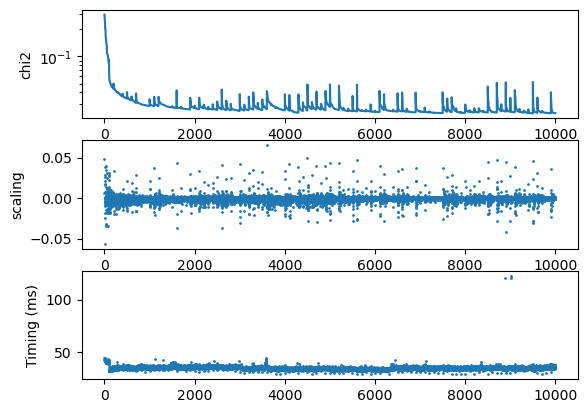

In [229]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3, 1)
ax[0].plot(chi_trace)
ax[0].set_yscale('log')
ax[0].set_ylabel('chi2')
ax[1].plot(scale_trace,'.', markersize=2)
ax[1].set_ylabel('scaling')
ax[2].plot(np.array(fine_timing_trace)*1000,'.', markersize=2)
ax[2].set_ylabel('Timing (ms)')


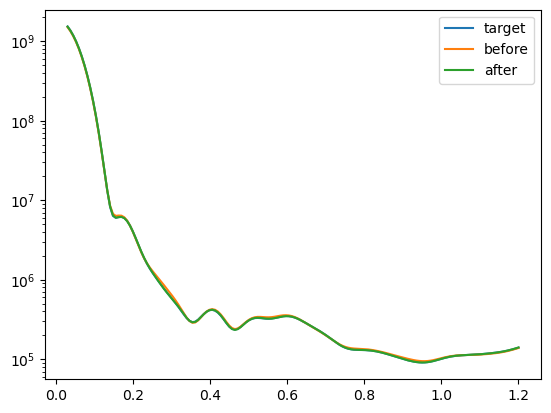

In [230]:

plt.plot(scatter.q, S_calc_all, label='target')
plt.yscale('log')
plt.plot(scatter.q, S_calc_pro_before, label='before')
plt.plot(scatter.q, final_S_calc, label='after')
# plt.plot(scatter.q, S_calc_trial, label='chain B')
# plt.plot(scatter.q, S_calc_cross, label='chain A x chain B')
# plt.plot(scatter.q, S_calc_pro + S_calc_trial + 2 * S_calc_cross, label='trial')
plt.legend()

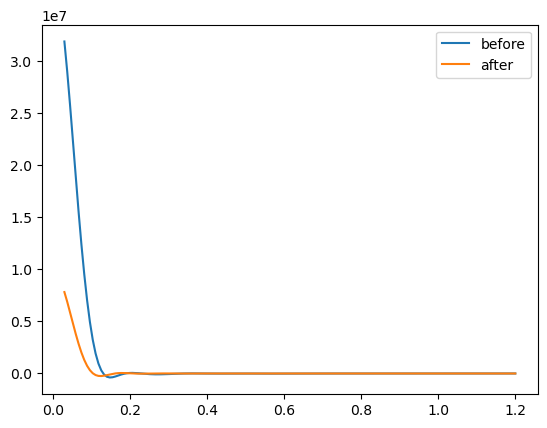

In [231]:
# plt.plot(scatter.q, S_calc_all, label='target')
# plt.yscale('log')
plt.plot(scatter.q, S_calc_all -S_calc_pro_before, label='before')
plt.plot(scatter.q, S_calc_all - final_S_calc, label='after')
# plt.plot(scatter.q, S_calc_trial, label='chain B')
# plt.plot(scatter.q, S_calc_cross, label='chain A x chain B')
# plt.plot(scatter.q, S_calc_pro + S_calc_trial + 2 * S_calc_cross, label='separate')
plt.legend()

In [180]:
import matplotlib.pyplot as plt
plt.plot(scatter.q, (S_calc_all - S_calc_pro) / S_calc_all)

NameError: name 'S_calc_pro' is not defined